In [10]:
import netCDF4 as nc
from netCDF4 import Dataset

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import xarray as xr

from scipy import signal
from scipy import stats

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn import linear_model
import statsmodels.api as sm

In [3]:
# directory paths
atmdir = "/global/project/projectdirs/m1199/iHESP/Atmosphere/"
ocndir = "/global/project/projectdirs/m1199/iHESP/Ocean/"
ocndirsc = "/global/cscratch1/sd/wilbert/iHESP/Ocean/"

# constants
a = 6.3781e6 
area = np.load("data/area.npy") # solid angle (multiply by a^2 to get area)

# colors for AHT terms
colors = {"Total": 'tomato',
         "SW TOA": 'gold',
         "SW sfc": 'orange', 
         "SW sfc clear-sky": 'darkorange',
         "LW TOA": 'lightskyblue', 
         "LW sfc": 'cornflowerblue',
         "SW+LW clear-sky": 'silver', 
         "SW+LW cloud": 'dimgrey',
         "LW cloud": "seagreen",
         "LW clear-sky": "slateblue",
         "SW cloud": "chocolate",
         "SW clear-sky": "goldenrod",
         "Latent": 'plum',
         "Sensible": 'violet',
         "SW": 'darkorange',
         "LW": 'deepskyblue',
         "Turbulent": 'mediumorchid',
         "TOA": "slateblue",
         "OHT": "crimson",
         "OHC": "palevioletred"}

# in:    t (1 to 50, decade for atmosphere; 21 to 519, year for ocean)
#        ocn (logical)
# out:   string corresponding to date range 
def getTimeRange(t, ocn):
    if ocn:
        # takes in t as a year
        initial = (t) * 100 + 1 
        final = (t) * 100 + 12
        return "00" + str(initial) + "-00" + str(final) if initial < 10000 else "0" + str(initial) + "-0" + str(final)
    else: 
        initial = (t + 1) * 1000 + 1 if t != 1 else (t + 1) * 1000 + 101
        final = (t + 1) * 1000 + 912
        return "00" + str(initial) + "-00" + str(final) if initial < 10000 else "0" + str(initial) + "-0" + str(final)

def getFileName(var, t, ocn):
    if ocn:
        return "B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h."+var+"."+getTimeRange(t,ocn)+".nc"
    else:
        return "B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.cam.h0."+var+"."+getTimeRange(t,ocn)+".gr.nc"
    
# in:    var (str)
#        directory (atmdir or ocndir)
#        t (1 to 50) corresponding to decade
#        getDataset 
#        domain 
# out:   data

# todo: add option to revert back to full spatial dataset

def getData(var, directory, t, lats=[0,257], lons=[0,512], z=[0,0], getDataset=False, ocn=False):
    if t == "all":
        if ocn:
            # initial data on which to append
            filename = getFileName(var, 170, ocn)
            data = xr.open_dataset(directory+var+"/"+filename).variables[var][:,z[0]:z[1],lats[0]:lats[1],lons[0]:lons[1]]
            for i in range(171,520,1):
                filename = getFileName(var, i, ocn)
                data = np.append(data, xr.open_dataset(directory+var+"/"+filename).variables[var][:, z[0]:z[1], lats[0]:lats[1], lons[0]:lons[1]], axis=0)
            return data
        else:
            # initial data on which to append
            filename = getFileName(var, 16, ocn)
            data = xr.open_dataset(directory+var+"/"+filename).variables[var][:,lats[0]:lats[1],lons[0]:lons[1]]
            
            for i in range(34):
                filename = getFileName(var, i+17, ocn)
                # append to time axis
                if z == [0,0]:
                    data = np.append(data, xr.open_dataset(directory+var+"/"+filename).
                                     variables[var][:, lats[0]:lats[1], lons[0]:lons[1]], axis=0)
                else:
                    data = np.append(data, xr.open_dataset(directory+var+"/"+filename).
                                     variables[var][:, z[0]:z[1], lats[0]:lats[1], lons[0]:lons[1]], axis=0)
        return data 
    else: 
        filename = getFileName(var, t, ocn)
        data = xr.open_dataset(directory+var+"/"+filename)
        
        if ocn:
            return data if getDataset else data.variables[var][:,z[0]:z[1],lats[0]:lats[1],lons[0]:lons[1]]
        else: 
            return data if getDataset else data.variables[var][:,lats[0]:lats[1],lons[0]:lons[1]]

# Description: gets data from ocean directory
# 
# In: fileVar (str) name of file variable 
#     var     (str) name of variable within file
#     t       (arr) initial and end year indices (exclusive)
#     z       (arr) depth indices 
#     lat     (arr) latitude indices
#     lon     (arr) longitude indices
# 
# Out: data (np array)

def getOcnData(fileVar, var, t, z, lat, lon):
    data = []
    for i in range(t[0],t[1]+1,1):
        data.append(nc.Dataset(ocndirsc+fileVar+"/"+getFileName(fileVar, i, True)).variables[var][:,z[0]:z[1],lat[0]:lat[1],lon[0]:lon[1]])
    return data

# takes running mean for first axis 
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0, axis=0), axis=0) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Description: regresses a spatial timeseries onto a linear timeseries (useful for OHT regression)
# 
# In: x (spatial timeseries that depends on y)
#     y (linear timeseries, e.g. OHT) 
# 
# Out: coef (array of dimensions [nlat, nlon, 2])
#      coef[:,:,0] is the spatial regression coefficients 
#      coef[:,:,1] is the p value

def regress_spatial(x, y): 
    nt, nlat, nlon = x.shape

    # regress using statsmodel (also gets p value for regression slope)
    reg = np.zeros((nlat, nlon, 2))

    for i in range(nlat):
        for j in range(nlon):
            if not x[0,i,j] == np.nan:
                fit = sm.OLS(x[:,i,j], y).fit()
                reg[i,j,0] = fit.params[0]
                reg[i,j,1] = fit.pvalues[0] 

    return reg

# Description: takes annual mean of a timeseries
# 
# In: a (spatial timeseries)
# 
# Out: a_ann (annual mean)

def annmean(a):
    dims = a.shape
    return np.mean(a.reshape(((-1, 12) + dims[1:])), axis=1) 

# Description: computes the southward cumulative integral of a flux.
#              useful for calculating AHT components 
#
# In: flx (spatial timeseries)
#
# Out: southward-integrated cumulative flux (timeseries as function of latitude)

def calcAHT(flx):
    nt, nlat, nlon = flx.shape
    area = np.load("data/area.npy")
    a = 6.3781e6     # radius of the earth in m
    
    # find the area integrated net flux for each grid cell
    fint = flx * area[(257-nlat):,:] * a**2

    fxint = fint.sum(axis=2) # integrate zonally 

    aht = np.flip(np.cumsum(np.flip(fxint, axis=1), axis=1), axis=1) # integrate meridionally
    
    return aht

# Description: calculates the compensation rate 
#
# In: AHT (detrended, demeaned, 10-yr moving mean) 
#     OHT (detrended, demeaned, 10-yr moving mean)
#
# Out: compensation rate (%) 

def calcCR(aht, oht):
    tht = aht + oht
    ht = np.abs(np.array([aht, oht]))
    return np.mean(1 - np.abs(tht)/np.max(ht,axis=0)) * 100

# Description: calculates a lagged correlation coefficient
#
# In: x (timeseries)
#     y (timeseries)
#     lag (lead lag time) 
#
# Out: r (array of length lag * 2 + 1)
# 
# Note: y leads x for positive lag

def laggedCorr(x, y, lag):
    if not x.shape == y.shape:
        raise ValueError('input arrays are not the same size')
    
    nt = len(x)
    
    corr = []
    
    for i in range(lag+1):
        corr.insert(0, stats.pearsonr(x[i:], y[0:(nt-i)])[0])
        if not i == 0:
            corr.append(stats.pearsonr(y[i:], x[0:(nt-i)])[0])
    
    return corr

lat = getData("FLNT", atmdir, 1, getDataset=True).variables["lat"][128:]
lon = getData("FLNT", atmdir, 1, getDataset=True).variables["lon"]


In [34]:
oht_comp = {
    "Global": xr.open_dataset(ocndir + "vTFlux_65N_Global.nc").variables['vTFlux_65N_Global'][169:],
    "GSR": xr.open_dataset(ocndir + "vTFlux_65N_GSR.nc").variables['vTFlux_65N_GSR'][169:],
    "Bering": xr.open_dataset(ocndir + "vTFlux_65N_Bering.nc").variables['vTFlux_65N_Bering'][169:],
    "Davis": xr.open_dataset(ocndir + "vTFlux_65N_Davis.nc").variables['vTFlux_65N_Davis'][169:]
}

oht_comp["Residual"] = oht_comp["Global"]-oht_comp["GSR"]-oht_comp["Bering"]-oht_comp["Davis"]

oht_filt = {}

oht_filt["Pacific"] = signal.detrend(running_mean(oht_comp["Bering"], 10))
oht_filt["Atlantic"] = signal.detrend(running_mean(oht_comp["Global"] - oht_comp["Bering"], 10))
oht_filt["Total"] = signal.detrend(running_mean(oht_comp["Global"], 10))

# stdev in TW
oht_std = {}

for term in oht_filt.keys():
    oht_std[term] = oht_filt[term].std() * 1000
print(oht_std)

print(np.mean(running_mean(oht_comp["Bering"], 10)), np.mean(running_mean(oht_comp["Global"] - oht_comp["Bering"], 10)))


{'Pacific': 1.3554361817044416, 'Atlantic': 10.542466591763565, 'Total': 11.051904174312865}
<xarray.Variable ()>
array(0.00860662) <xarray.Variable ()>
array(0.3425511)


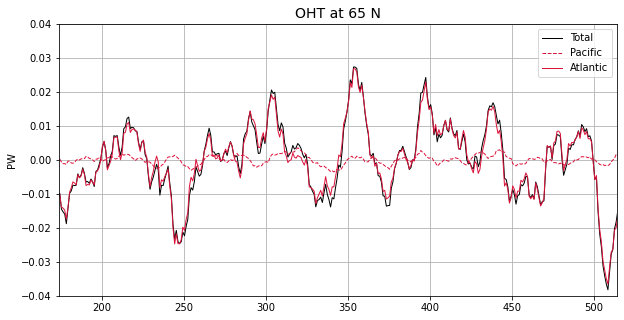

In [16]:
t = np.linspace(174.5,514.5,341)

oht_style = {
    "Pacific": "dashed",
    "Atlantic": "solid",
    "Total": "solid"
}

oht_color = {
    "Pacific": "crimson",
    "Atlantic": "crimson",
    "Total": "k"
}

figure(figsize=(10,5))

for term in ["Total", "Pacific", "Atlantic"]:
    plt.plot(t, oht_filt[term], label=term, 
             linestyle=oht_style[term], color=oht_color[term], linewidth=1)

plt.title("OHT at 65 N", fontsize=14)
plt.xlim([174,514])
plt.ylim([-0.04,0.04])
plt.grid(True)
plt.ylabel("PW")
plt.legend()

In [6]:
%%time
# load the heat fluxes

# radiative fluxes
flns = np.load("data/rflx/FLNS_ann.npy") 
flnt = np.load("data/rflx/FLNT_ann.npy")
fsns = np.load("data/rflx/FSNS_ann.npy")
fsnt = np.load("data/rflx/FSNT_ann.npy")

flnsc = np.load("data/rflx/FLNSC_ann.npy")
flntc = np.load("data/rflx/FLNTC_ann.npy")
fsntc = np.load("data/rflx/FSNTC_ann.npy")
fsnsc = np.load("data/rflx/FSNSC_ann.npy")

# sensible and latent heat flux
shflx = np.load("data/SHFLX_ann.npy")
lhflx = np.load("data/LHFLX_ann.npy")


CPU times: user 0 ns, sys: 670 ms, total: 670 ms
Wall time: 678 ms


note: heat fluxes are positive going *into* the atmosphere 

In [7]:
%%time

# annual-mean spatial atmospheric fields we are interested in

lw_budget = {
    "Surface, clear-sky": flnsc,
    "TOA, clear-sky": -flntc,
    "Total, clear-sky": flnsc - flntc,
    "Surface, cloud": flns - flnsc,
    "TOA, cloud": flntc - flnt,
    "Total, cloud": flns - flnsc + flntc - flnt,
    "Surface, all-sky": flns,
    "TOA, all-sky": -flnt,
    "Total": flns - flnt
}

sw_budget = {
    "Surface, clear-sky": -fsnsc,
    "TOA, clear-sky": fsntc,
    "Total, clear-sky": fsntc - fsnsc,
    "Surface, cloud": -fsns + fsnsc,
    "TOA, cloud": -fsntc + fsnt,
    "Total, cloud": -fsns + fsnsc - fsntc + fsnt,
    "Surface, all-sky": -fsns,
    "TOA, all-sky": fsnt,
    "Total": -fsns + fsnt
}

hflx_budget = {
    "Latent": lhflx,
    "Sensible": shflx,
    "Turbulent": lhflx + shflx,
    "Turbulent + radiative": lhflx + shflx + flns - flnt - fsns + fsnt
}

CPU times: user 625 ms, sys: 787 ms, total: 1.41 s
Wall time: 1.41 s


In [31]:
# double check the signs are right

print(f'LW clear-sky residual: {np.sum(lw_budget["Total, clear-sky"][0,:,:] - lw_budget["Surface, clear-sky"][0,:,:] - lw_budget["TOA, clear-sky"][0,:,:])}')
print(f'SW clear-sky residual: {np.sum(sw_budget["Total, clear-sky"][0,:,:] - sw_budget["Surface, clear-sky"][0,:,:] - sw_budget["TOA, clear-sky"][0,:,:])}')

print(f'LW cloud residual: {np.sum(lw_budget["Total, cloud"][0,:,:] - lw_budget["Surface, cloud"][0,:,:] - lw_budget["TOA, cloud"][0,:,:])}')
print(f'SW cloud residual: {np.sum(sw_budget["Total, cloud"][0,:,:] - sw_budget["Surface, cloud"][0,:,:] - sw_budget["TOA, cloud"][0,:,:])}')



LW clear-sky residual: 0.003173828125
SW clear-sky residual: -9.5367431640625e-05
LW cloud residual: -0.0002288818359375
SW cloud residual: 0.00374603271484375


In [35]:
%%time

# normalize the oht timeseries by dividing by the stdev
oht_norm = {}

for term in oht_filt.keys():
    oht_norm[term] = oht_filt[term] / oht_filt[term].std()
    
# 10-yr moving mean and subtract out the mean for all atmospheric fields
lw_budget_movmean = {}
sw_budget_movmean = {}
hflx_budget_movmean = {}

for term in lw_budget:
    lw_budget_movmean[term] = signal.detrend(running_mean(lw_budget[term],10), axis=0)

for term in sw_budget:
    sw_budget_movmean[term] = signal.detrend(running_mean(sw_budget[term],10), axis=0)
    
for term in hflx_budget:
    hflx_budget_movmean[term] = signal.detrend(running_mean(hflx_budget[term],10), axis=0)

CPU times: user 21.4 s, sys: 9.57 s, total: 30.9 s
Wall time: 22.1 s


In [36]:
%%time

test_reg = regress_spatial(hflx_budget_movmean["Turbulent"], oht_norm["Pacific"])

CPU times: user 1min 41s, sys: 4.65 s, total: 1min 46s
Wall time: 53.2 s


In [41]:
def regress_spatial_no_p(x, y): 
    nt, nlat, nlon = x.shape

    # regress using statsmodel (also gets p value for regression slope)
    reg = np.zeros((nlat, nlon))

    for i in range(nlat):
        for j in range(nlon):
            if not x[0,i,j] == np.nan:                
                lm = linear_model.LinearRegression()
                lm.fit(x[:,i,j].reshape(-1,1), y)
                    
                reg[i,j] = lm.coef_

    return reg


In [42]:
%%time

test_reg_no_p = regress_spatial_no_p(hflx_budget_movmean["Turbulent"], oht_norm["Pacific"])

CPU times: user 1min 23s, sys: 3.82 s, total: 1min 27s
Wall time: 43.5 s


takes about the same time!

In [52]:
# regress only north of 65 N 

print(lat[92])


<xarray.Variable ()>
array(64.6875)
Attributes:
    long_name:      Latitude of Grid Cell Centers
    standard_name:  latitude
    units:          degrees_north
    axis:           Y
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         lat_bnds


In [55]:
oht_abbrev = {
    "Pacific": "Pcf",
    "Atlantic": "Atl"
}

for term in lw_budget_movmean:
    for oht_term in ["Pacific", "Atlantic"]:
        reg = regress_spatial(lw_budget_movmean[term][:,92:,:], oht_norm[oht_term]) 
        
        # save the regression 
        np.save(f'data/rflx_sector_reg/{oht_term}/LW/{term}', reg)
        
        #lw_oht_regression[f'{oht_abbrev[oht_term]} {term}'] = reg



In [56]:
for term in sw_budget_movmean:
    for oht_term in ["Pacific", "Atlantic"]:
        reg = regress_spatial(sw_budget_movmean[term][:,92:,:], oht_norm[oht_term]) 
        
        # save the regression 
        np.save(f'data/rflx_sector_reg/{oht_term}/SW/{term}', reg)
        
        #sw_oht_regression[f'{oht_abbrev[oht_term]} {term}'] = reg

for term in hflx_budget_movmean:
    for oht_term in ["Pacific", "Atlantic"]:
        reg = regress_spatial(hflx_budget_movmean[term][:,92:,:], oht_norm[oht_term]) 
        
        # save the regression 
        np.save(f'data/rflx_sector_reg/{oht_term}/hflx/{term}', reg)


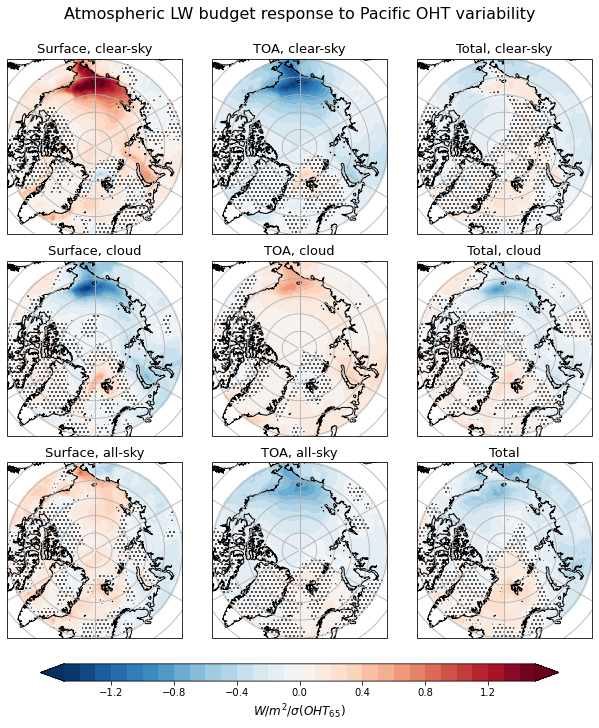

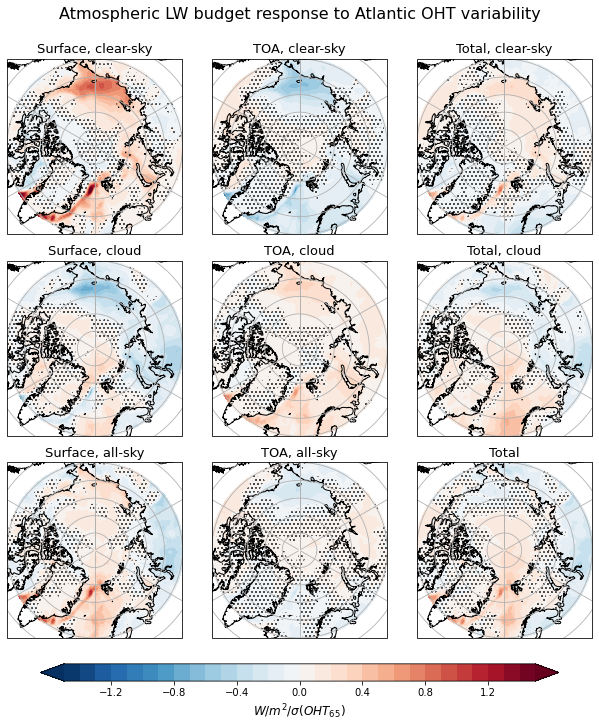

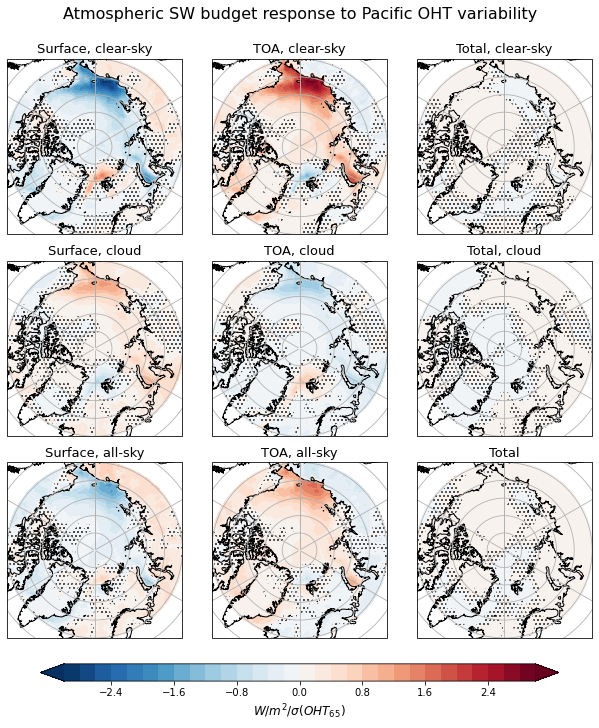

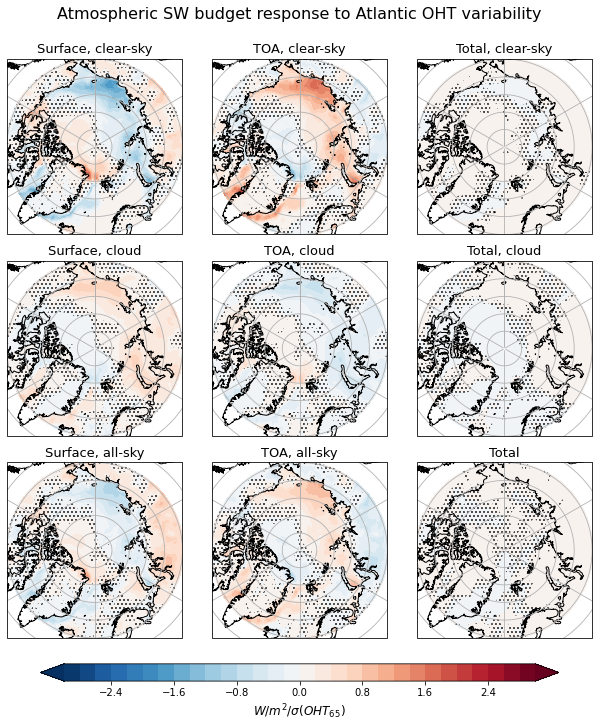

In [60]:
lat_n_of_65 = lat[92:]

ranges = {
    "LW": np.arange(-1.5, 1.6, 0.1),
    "SW": np.arange(-3.0, 3.2, 0.2)
}

for rflx_term in ["LW", "SW"]:
    for oht_term in ["Pacific", "Atlantic"]:
        fig, axs = plt.subplots(nrows=3,ncols=3,
                                subplot_kw={'projection': ccrs.NorthPolarStereo()},
                                figsize=(12,12))

        axs=axs.flatten()

        for i,term in enumerate(lw_budget.keys()):
            data = np.load(f'data/rflx_sector_reg/{oht_term}/{rflx_term}/{term}.npy')

            # get p < 0.05
            insignificant_mask = data[:,:,0].copy()
            insignificant_mask[data[:,:,1] < 0.05] = np.nan

            cs = axs[i].contourf(lon, lat_n_of_65, data[:,:,0], ranges[rflx_term], 
                              cmap='RdBu_r', transform=ccrs.PlateCarree(), extend="both")
            axs[i].contourf(lon, lat_n_of_65, (insignificant_mask[:,:]), 
                            colors='none', hatches=["."*3], transform=ccrs.PlateCarree())
            axs[i].set_title(term, fontsize=13)
            axs[i].coastlines()
            axs[i].set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
            axs[i].gridlines()


        fig.subplots_adjust(bottom=0.25, top=0.92, left=0.15, right=0.85,
                            wspace=0.05, hspace=0.15)

        cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
        cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
        cbar.set_label("$W/m^2/\sigma(OHT_{65})$", fontsize=12)

        fig.suptitle(f'Atmospheric {rflx_term} budget response to {oht_term} OHT variability', fontsize=16)
        
        fig.savefig(f'figures/{rflx_term}_{oht_term}_reg.png')
        fig.savefig(f'figures/{rflx_term}_{oht_term}_reg.svg')

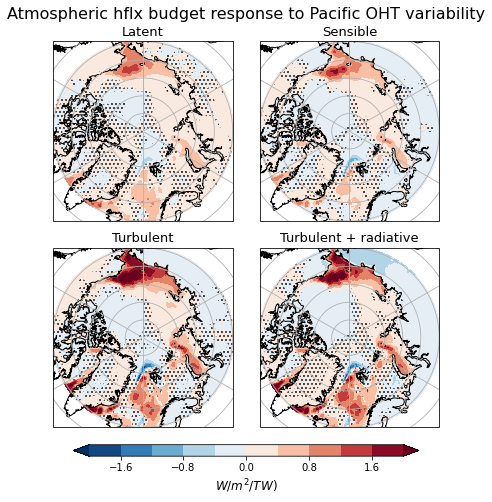

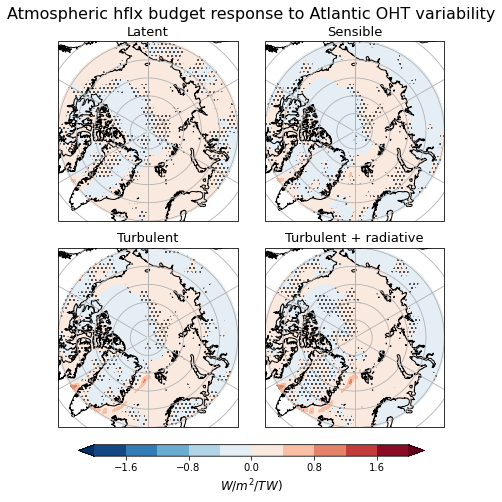

In [12]:
lat_n_of_65 = lat[92:]

ranges = {
    "Pacific": np.arange(-2, 2.4, 0.4),
    "Atlantic": np.arange(-2, 2.4, 0.4)
}

for oht_term in ["Pacific", "Atlantic"]:
    fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(8,8))

    axs=axs.flatten()

    for i,term in enumerate(hflx_budget.keys()):
        data = np.load(f'data/rflx_sector_reg/{oht_term}/hflx/{term}.npy')

        # get p < 0.05
        insignificant_mask = data[:,:,0].copy()
        insignificant_mask[data[:,:,1] < 0.05] = np.nan

        cs = axs[i].contourf(lon, lat_n_of_65, data[:,:,0] / oht_std[oht_term], ranges[oht_term],
                          cmap='RdBu_r', transform=ccrs.PlateCarree(), extend="both")
        axs[i].contourf(lon, lat_n_of_65, (insignificant_mask[:,:]), 
                        colors='none', hatches=["."*3], transform=ccrs.PlateCarree())
        axs[i].set_title(term, fontsize=13)
        axs[i].coastlines()
        axs[i].set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
        axs[i].gridlines()


    fig.subplots_adjust(bottom=0.25, top=0.92, left=0.15, right=0.85,
                        wspace=0.05, hspace=0.15)

    cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("$W/m^2/TW)$", fontsize=12)

    fig.suptitle(f'Atmospheric hflx budget response to {oht_term} OHT variability', fontsize=16)

    #fig.savefig(f'figures/no_norm/hflx_{oht_term}_reg.png')
    #fig.savefig(f'figures/no_norm/hflx_{oht_term}_reg.svg')


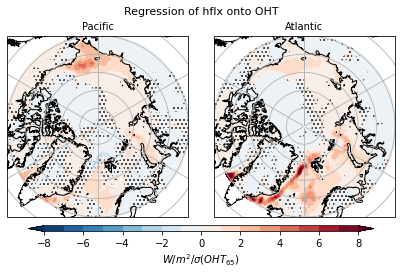

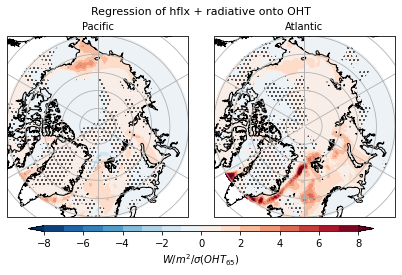

In [33]:
lat_n_of_65 = lat[92:]

ranges = {
    "Pacific": np.arange(-4, 4.5, 0.5),
    "Atlantic": np.arange(-8, 9, 1)
}

abbrev = {
    "Turbulent": "hflx",
    "Turbulent + radiative": "hflx + radiative"
}

for term in ["Turbulent", "Turbulent + radiative"]:
    fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(8,4))

    axs=axs.flatten()

    for i,oht_term in enumerate(["Pacific", "Atlantic"]):
        data = np.load(f'data/rflx_sector_reg/{oht_term}/hflx/{term}.npy')

        # get p < 0.05
        insignificant_mask = data[:,:,0].copy()
        insignificant_mask[data[:,:,1] < 0.05] = np.nan

        cs = axs[i].contourf(lon, lat_n_of_65, data[:,:,0], np.arange(-8, 9, 1),
                          cmap='RdBu_r', transform=ccrs.PlateCarree(), extend="both")
        axs[i].contourf(lon, lat_n_of_65, (insignificant_mask[:,:]), 
                        colors='none', hatches=["."*3], transform=ccrs.PlateCarree())
        axs[i].set_title(oht_term, fontsize=10)
        axs[i].coastlines()
        axs[i].set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
        axs[i].gridlines()


    fig.subplots_adjust(bottom=0.25, top=0.88, left=0.15, right=0.85,
                        wspace=0.05, hspace=0.15)

    cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
    cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("$W/m^2/\sigma(OHT_{65})$", fontsize=10)

    fig.suptitle(f'Regression of {abbrev[term]} onto OHT', fontsize=11)

    #fig.savefig(f'figures/no_norm/hflx_{oht_term}_reg.png')
    fig.savefig(f'figures/sector_regress/{abbrev[term]}_reg.svg')


In [66]:
# other atmospheric fields we do regression on:

atm_fields_mon = {
    "TS": getData("TS", atmdir, "all", [128,257]),
    "CLDLOW": getData("CLDLOW", atmdir, "all", [128,257]),
    "CLDHGH": getData("CLDHGH", atmdir, "all", [128,257]),
    "CLDMED": getData("CLDMED", atmdir, "all", [128,257]) 
}

# turn them into annual fields

atm_fields_ann = {}

for term in atm_fields_mon.keys():
    a = annmean(atm_fields_mon[term])
    atm_fields_ann[term] = a
    
    np.save(f'data/{term}_ann', a)

In [95]:
atm_fields_ann["ICEFRAC"] = np.load("data/icefrac_ann.npy")

# 10-yr moving mean and detrend, then do the regressions
atm_fields_movmean = {}

for var in atm_fields_ann.keys():
    atm_fields_movmean[var] = signal.detrend(running_mean(atm_fields_ann[var], 10), axis=0)
    print(f'{var} smoothing done; mean = {np.mean(atm_fields_movmean[var])}\nshape = {atm_fields_movmean[var].shape}\n')

# compute regression map
atm_fields_reg = {}

for var in atm_fields_movmean.keys():
    for oht_term in ["Pacific", "Atlantic"]:
        reg = regress_spatial(atm_fields_movmean[var][:,92:,:], oht_norm[oht_term]) 
        print(f'{var} vs {oht_term} regression done')
        
        # save the regression 
        np.save(f'data/oht_comp_reg_map/{oht_term}/{var}', reg)
        
        atm_fields_reg[f'{oht_abbrev[oht_term]} {var}'] = reg
        print(f'{var} vs {oht_term} regression saved\n')



TS smoothing done; mean = -1.3875355762138497e-05
shape = (341, 129, 512)

CLDLOW smoothing done; mean = -2.295809942154392e-08
shape = (341, 129, 512)

CLDHGH smoothing done; mean = -1.88060305106319e-08
shape = (341, 129, 512)

CLDMED smoothing done; mean = -1.2909304736297145e-08
shape = (341, 129, 512)

ICEFRAC smoothing done; mean = -8.098012038715297e-09
shape = (341, 129, 512)

TS vs Pacific regression done
TS vs Pacific regression saved

TS vs Atlantic regression done
TS vs Atlantic regression saved

CLDLOW vs Pacific regression done
CLDLOW vs Pacific regression saved

CLDLOW vs Atlantic regression done
CLDLOW vs Atlantic regression saved

CLDHGH vs Pacific regression done
CLDHGH vs Pacific regression saved

CLDHGH vs Atlantic regression done
CLDHGH vs Atlantic regression saved

CLDMED vs Pacific regression done
CLDMED vs Pacific regression saved

CLDMED vs Atlantic regression done
CLDMED vs Atlantic regression saved

ICEFRAC vs Pacific regression done
ICEFRAC vs Pacific regres

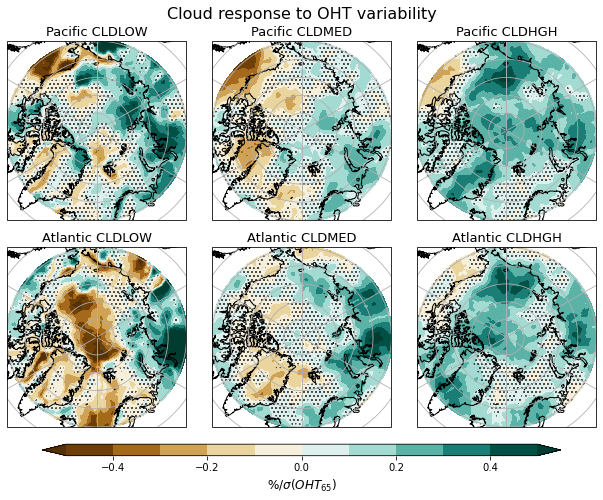

In [99]:
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(12,8))

axs = axs.flatten()

for j,oht_term in enumerate(["Pacific", "Atlantic"]):
    for i,var in enumerate(["CLDLOW", "CLDMED", "CLDHGH"]):
        data = np.load(f'data/oht_comp_reg_map/{oht_term}/{var}.npy')

        # get p < 0.05
        insignificant_mask = data[:,:,0].copy()
        insignificant_mask[data[:,:,1] < 0.05] = np.nan
        

        cs = axs[j*3+i].contourf(lon, lat_n_of_65, data[:,:,0] * 100, np.arange(-0.5, 0.6, 0.1),
                          cmap='BrBG', transform=ccrs.PlateCarree(), extend="both")
        axs[j*3+i].contourf(lon, lat_n_of_65, (insignificant_mask), colors='none', hatches=['.'*3],
                        transform=ccrs.PlateCarree())
        axs[j*3+i].set_title(f'{oht_term} {var}', fontsize=13)
        axs[j*3+i].coastlines()
        axs[j*3+i].set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
        axs[j*3+i].gridlines()


fig.subplots_adjust(bottom=0.25, top=0.92, left=0.15, right=0.85,
                    wspace=0.05, hspace=0.15)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label("$\%/\sigma(OHT_{65})$", fontsize=12)

fig.suptitle(f'Cloud response to OHT variability', fontsize=16)
fig.savefig('figures/cloud_reg.png')
fig.savefig('figures/cloud_reg.svg')

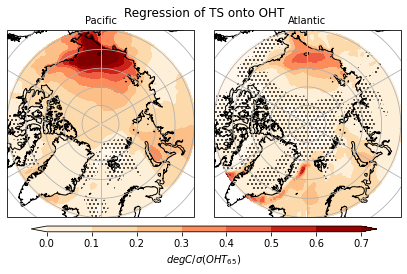

In [4]:
lat_n_of_65 = lat[92:]

fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(8,4))

axs = axs.flatten()

for i,oht_term in enumerate(["Pacific", "Atlantic"]):
    data = np.load(f'data/oht_comp_reg_map/{oht_term}/TS.npy')

    # get p < 0.05
    insignificant_mask = data[:,:,0].copy()
    insignificant_mask[data[:,:,1] < 0.05] = np.nan


    cs = axs[i].contourf(lon, lat_n_of_65, data[:,:,0], np.arange(0, 0.8, 0.1),
                      cmap='OrRd', transform=ccrs.PlateCarree(), extend="both")
    axs[i].contourf(lon, lat_n_of_65, (insignificant_mask), colors='none', hatches=['.'*3],
                    transform=ccrs.PlateCarree())
    axs[i].set_title(f'{oht_term}', fontsize=10)
    axs[i].coastlines()
    axs[i].set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    axs[i].gridlines()


fig.subplots_adjust(bottom=0.25, top=0.90, left=0.15, right=0.85,
                    wspace=0.05, hspace=0.15)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label("$deg C/\sigma(OHT_{65})$", fontsize=10)

fig.suptitle(f'Regression of TS onto OHT', fontsize=12)
fig.savefig('figures/sector_regress/ts.svg', bbox_inches='tight')

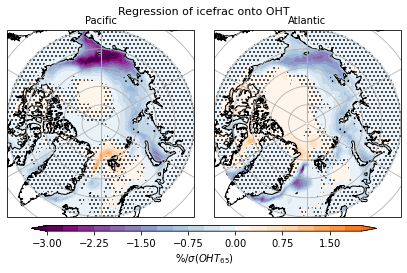

In [27]:
top = cm.get_cmap('BuPu_r', 120)
bottom = cm.get_cmap('Oranges', 120)

newcolors = np.vstack((top(np.linspace(0, 1, 120)),
                       bottom(np.linspace(0, 0.6, 72))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

lat_n_of_65 = lat[92:]

fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(8,4))

axs = axs.flatten()

for i,oht_term in enumerate(["Pacific", "Atlantic"]):
    data = np.load(f'data/oht_comp_reg_map/{oht_term}/ICEFRAC.npy')

    # get p < 0.05
    insignificant_mask = data[:,:,0].copy()
    insignificant_mask[data[:,:,1] < 0.05] = np.nan


    cs = axs[i].contourf(lon, lat_n_of_65, data[:,:,0]*100, np.arange(-3, 2.25, 0.25),
                      cmap=newcmp, transform=ccrs.PlateCarree(), extend="both")
    axs[i].contourf(lon, lat_n_of_65, (insignificant_mask), colors='none', hatches=['.'*3],
                    transform=ccrs.PlateCarree())
    axs[i].set_title(f'{oht_term}', fontsize=10)
    axs[i].coastlines()
    axs[i].set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    axs[i].gridlines()


fig.subplots_adjust(bottom=0.25, top=0.90, left=0.15, right=0.85,
                    wspace=0.05, hspace=0.15)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label("$\%/\sigma(OHT_{65})$", fontsize=10)

fig.suptitle(f'Regression of icefrac onto OHT', fontsize=11)
fig.savefig('figures/sector_regress/icefrac.svg', bbox_inches='tight')

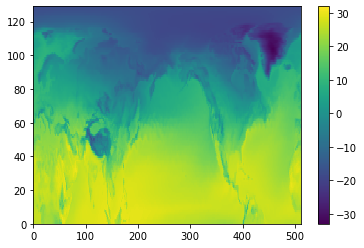

In [38]:
ts = np.load("data/TS_ann.npy")

plt.pcolormesh(ts[10,:,:] - 273)
plt.colorbar()